In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from fastai.text import *

In [0]:
BASE_PATH = Path('drive/My Drive/Google Colab/DL-project')
DATA_PATH = BASE_PATH/"emobank.csv"

In [0]:
df = pd.read_csv(DATA_PATH)

In [0]:
df.head(5)

,id,split,V,A,D,text
0,110CYL068_1036_1079,train,3.00,3.00,3.20,"Remember what she said in my last letter? """
1,110CYL068_1079_1110,test,2.80,3.10,2.80,If I wasn't working here.
2,110CYL068_1127_1130,train,3.00,3.00,3.00,".."""
3,110CYL068_1137_1188,train,3.44,3.00,3.22,Goodwill helps people get off of public assist...
4,110CYL068_1189_1328,train,3.55,3.27,3.46,Sherry learned through our Future Works class ...


In [0]:
list(df['text'])

In [0]:
df.shape

(10062, 6)

In [0]:
df['split'].value_counts()

train    8062
dev      1000
test     1000
Name: split, dtype: int64

In [0]:
def assign(x):
  if x == 'dev' or x == 'test':
    return True
  else:
    return False

In [0]:
df['split'] = df['split'].apply(assign)

In [0]:
df['split'].value_counts()

False    8062
True     2000
Name: split, dtype: int64

In [0]:
path = BASE_PATH
path.ls()
# bs = 48

[PosixPath('drive/My Drive/Google Colab/DL-project/emobank.csv')]

In [0]:
data_lm = (TextList.from_df(df, path, cols=["text"])
                  .random_split_by_pct(0.1)
                  .label_for_lm()
                  .databunch(bs=bs))

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:215: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [0]:
data_lm.show_batch()

idx,text
0,"am now ... totally off of welfare . "" xxbos xxmaj goodwill xxunk people for life - long employment . xxbos xxmaj here 's another story of success from what might seem like an unlikely source : xxmaj goodwill 's xxunk , xxmaj xxunk . xxbos xxmaj xxunk found a number of employment options that he never xxunk existed after a work - site injury forced him out of his"
1,"every year we seek companies , organizations and individuals to sponsor one or more of our families . xxbos xxmaj these families are participants in our community - based programs . xxbos xxmaj these programs focus on keeping the family together by providing counseling and other services to the entire family . xxbos xxmaj after our xxunk meet with these families and their children they often find they lack even"
2,"mccoy , xxmaj inc. has been to make a difference . xxbos xxmaj one group of adults and one group of youth , through two very different xxunk , have arrived at the same conclusion ; our community still has much to do if we are to help xxup all of your youth successfully develop into the responsible , productive adults who will our community in the future . xxbos"
3,""" separate the humanitarian work from the political issues . "" xxbos xxup xxunk , xxmaj jordan ( xxup ap ) xxbos xxmaj during his four days in xxmaj iraq , xxmaj hall said he wanted to investigate reports from relief agencies that a quarter of xxmaj iraqi children may be suffering from xxunk xxunk . xxbos xxup u.s. xxmaj representative xxmaj tony xxmaj hall arrived in xxmaj jordan on"
4,"xxunk , was auctioned xxmaj tuesday last night for a record price for a coin , $ xxunk million , nearly double the previous record . xxbos xxmaj the xxunk buyer , believed to be an individual collector who lives in the xxmaj united xxmaj states , made the winning bid in a xxunk xxunk nine - minute auction at xxmaj sotheby 's in xxmaj manhattan . xxbos xxmaj eight"


In [0]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [0]:
vocab = data_lm.vocab

In [0]:
TEXT = "The summer is"
N_WORDS = 40
N_SENTENCES = 2

print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The summer is Friday , the first Friday night of the January – February period , and the first Friday , the first part of Friday the 17th with the Friday the 17th in Friday
The summer is a traditional Winter Era , with many small parties and traditional events . The Care Bears Carnival is a traditional celebration of the Summer Olympics , and also includes the Winter


In [0]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


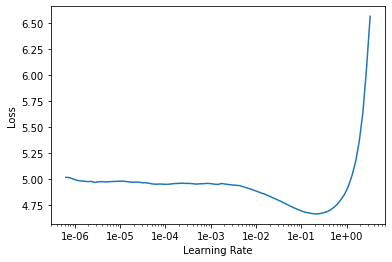

In [0]:
learn_lm.recorder.plot()

In [0]:
lr = 1e-2
# lr *= bs/48

In [0]:
learn_lm.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.303964,4.011925,0.228571,00:11
1,3.742675,3.991700,0.214286,00:10


In [0]:
learn_lm.unfreeze()

In [0]:
learn_lm.fit_one_cycle(3, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.501353,3.963438,0.271429,00:11
1,3.230389,4.014949,0.328571,00:11
2,2.455028,4.159099,0.285714,00:11


In [0]:
learn_lm.save("fine_tuned")

In [0]:
learn_lm.save_encoder('fine_tuned_enc')

In [0]:
#learn_lm.load_encoder('fine_tuned_enc')

In [0]:
data_regr = (TextList.from_df(df=df, path=path, cols='text', vocab=data_lm.vocab)
             .split_from_df(col='split')
             .label_from_df(cols=['V','A','D'], label_cls=FloatList)
             .databunch())

In [0]:
len(data_regr.train_dl)

125

In [0]:
data_regr.show_batch()

text,target
"xxbos xxmaj in another traditional xxunk story , “ xxmaj xxunk xxmaj shih - xxmaj niang xxmaj sinks the xxmaj xxunk xxmaj box in xxmaj anger , “ xxmaj xxunk xxmaj shih - xxmaj niang xxmaj sinks the xxmaj xxunk xxmaj box in xxmaj anger , ” trans , xxmaj richard xxup m. xxup w. xxmaj xxunk , in xxup y. xxup w. xxmaj ma and xxmaj joseph xxup s.",[2.9 2.9 3. ]
"xxbos xxmaj further , the committee notes section xxunk ) of the xxmaj senate xxmaj gift xxmaj rule ( 35 ) concerning anything which is paid for at market value or returned . . . as well as your commitment to pay for any item which the committee might xxunk were in violation of the rules , and has further concluded that you must pay xxmaj chang an amount xxunk",[2.9 2.7 3. ]
"xxbos xxmaj when discussing the role of parents and xxunk in a child ’s sexuality , he commented “ xxmaj they can bring you up [ to be ] open minded to [ homosexuality ] , but they do n’t bring you up [ to be a homosexual ] … i grew up in a place where [ homosexuality is accepted ] , so that ’s why i ’m so",[3. 3. 3.]
"xxbos xxmaj for two years , these men studied the number of occurrences of homosexuality in both xxunk , or identical twins ( a set of twins coming from the same xxunk egg and thus having identical xxup dna ) , and xxunk , or xxunk twins ( a set of twins from too separate xxunk , causing them to have similar xxup dna , but not any more so",[3. 3. 3.14]
"xxbos “ xxmaj xxunk xxmaj shih - xxmaj niang xxmaj sinks the xxmaj xxunk xxmaj box in xxmaj anger , “ xxmaj xxunk xxmaj shih - xxmaj niang xxmaj sinks the xxmaj xxunk xxmaj box in xxmaj anger , ” trans , xxmaj richard xxup m. xxup w. xxmaj xxunk , in xxup y. xxup w. xxmaj ma and xxmaj joseph xxup s. xxup m. xxmaj lau . xxmaj traditional",[3. 3. 3.1]


In [0]:
learn = text_classifier_learner(data_regr, AWD_LSTM, drop_mult=0.3,metrics = rmse)
learn.loss_func=MSELossFlat()
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


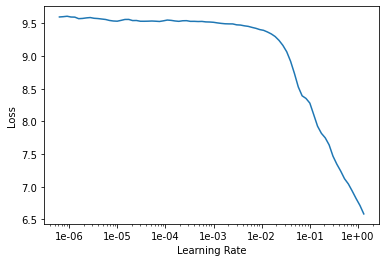

In [0]:
learn.recorder.plot()

In [0]:
lr = 3e-2

In [0]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.387430,0.071282,0.264375,00:10


In [0]:
learn.save('first')

In [0]:
#learn.load('first')

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.085974,0.063857,0.250118,00:12


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.077736,0.060036,0.243030,00:10


In [0]:
learn.save('third')

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.071463,0.060184,0.243209,00:13
1,0.068483,0.058854,0.240386,00:11


In [0]:
learn.predict("A fundraiser dedicated to you and you having fun")

(FloatItem [3.540498 3.269486 3.290179],
 tensor([3.5405, 3.2695, 3.2902]),
 tensor([3.5405, 3.2695, 3.2902]))

In [0]:
learn.predict("Many of the children have learning disabilities, behavioral problems, or come from economically distressed families.")

(FloatItem [2.740778 3.014001 2.960551],
 tensor([2.7408, 3.0140, 2.9606]),
 tensor([2.7408, 3.0140, 2.9606]))

In [0]:
learn.predict("yes! yes! yes! let's do it")

(FloatItem [4.122722 4.062442 3.785894],
 tensor([4.1227, 4.0624, 3.7859]),
 tensor([4.1227, 4.0624, 3.7859]))

In [0]:
learn.predict("Fuck you!")

(FloatItem [3.029834 4.015876 3.407761],
 tensor([3.0298, 4.0159, 3.4078]),
 tensor([3.0298, 4.0159, 3.4078]))

In [0]:
## To do - reverse and teach

In [0]:
learn.predict("I admire your coding skills!")

(FloatItem [3.413165 4.007046 3.542338],
 tensor([3.4132, 4.0070, 3.5423]),
 tensor([3.4132, 4.0070, 3.5423]))

In [0]:
learn.predict("I'm in love with you!")

(FloatItem [3.841689 4.052391 3.677698],
 tensor([3.8417, 4.0524, 3.6777]),
 tensor([3.8417, 4.0524, 3.6777]))

In [0]:
learn.predict("Amazing!")

(FloatItem [4.37727  4.834956 4.100627],
 tensor([4.3773, 4.8350, 4.1006]),
 tensor([4.3773, 4.8350, 4.1006]))

In [0]:
learn.predict("Disgusting!")

(FloatItem [3.224688 3.94572  3.459103],
 tensor([3.2247, 3.9457, 3.4591]),
 tensor([3.2247, 3.9457, 3.4591]))